# Spokane Solar Suitability
### Areeba Usman & Rose Martin
### 
---

## Section 0: Load in data and import packages

In [1]:
!pip install -q censusdata

In [2]:
import os
import shutil
import zipfile
import requests
import censusdata
import rasterstats
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path
import contextily as ctx
from scipy.ndimage import label
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xyzservices.providers as xyz
from rasterio.features import rasterize
from rasterio import plot, mask, features
from rasterio.transform import from_origin
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon, shape, box
from rasterio.warp import calculate_default_transform, reproject, Resampling

---
## Section 1: Loading Zone
### Census Data

In [3]:
#Functions taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]



In [4]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
}

In [5]:
## FIPS Code for Washington
state_fips = '53' 

## FIPS code for Spokane County
county_fips = '063'  

In [6]:
census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
tract_geom_gdf_fo_proj = tract_geom_gdf

In [7]:
census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
#census_df.head()

#### AEA Projection around Spokane

In [8]:
hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull
cent = hull.centroid

cent_lon =cent.x
cent_lat = cent.y
min_lat = tract_geom_gdf_fo_proj.bounds["miny"].min().item()
max_lat = tract_geom_gdf_fo_proj.bounds["maxy"].max().item()

/tmp/ipykernel_271/2544106682.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull


In [9]:
proj_str_aea = f'+proj=aea +lat_1={min_lat:0.2f} +lat_2={max_lat:0.2f} +lat_0={cent_lat:0.2f} +lon_0={cent_lon:0.2f}'
print(proj_str_aea)

+proj=aea +lat_1=47.26 +lat_2=48.05 +lat_0=47.64 +lon_0=-117.42


### States

In [10]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.6065, -70.82374 4..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.0577 44.99743, -104.25014 44.99..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.0506 37.0004, -114.05 36.95777,..."


In [11]:
## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)

WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

### Flood Plains

In [12]:
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn)

In [13]:
floodplains_gdf = floodplains_gdf.set_crs(4326)
floodplains_gdf.head()

,OBJECTID,FLD_ZONE,FloodZone,FloodDescription,ShapeSTArea,ShapeSTLength,geometry
0,1,AE,100 Year,1 Percent Annual Chance Flood Zone,2563.373517,1057.303252,"POLYGON ((-117.21347 47.71921, -117.21342 47.7..."
1,2,AE,100 Year,1 Percent Annual Chance Flood Zone,47091.207776,1316.843587,"POLYGON ((-117.39354 47.5726, -117.3937 47.572..."
2,3,X,500 Year,0.2 Percent Annual Chance Flood Zone,12072.635706,1139.022057,"POLYGON ((-117.41693 47.66159, -117.41703 47.6..."
3,4,AE,100 Year,1 Percent Annual Chance Flood Zone,3293.344152,385.964150,"POLYGON ((-117.33046 47.92931, -117.33022 47.9..."
4,5,X,500 Year,0.2 Percent Annual Chance Flood Zone,140930.032756,2078.807675,"POLYGON ((-117.78801 47.42675, -117.78808 47.4..."


#### Binary Flood Plain Raster

In [14]:
# Reproject to projected CRS
floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)
tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

# Get bounds of the area of interest
xmin, ymin, xmax, ymax = tract_geom_gdf.total_bounds

# Define the resolution of the raster (in meters)
resolution = 100  # Change as needed
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Define transform for rasterization
transform = from_origin(xmin, ymax, resolution, resolution)

# Create binary raster mask of floodplain areas (value = 0)
shapes_floodplain = [(geom, 0) for geom in floodplains_gdf.geometry]
raster = rasterize(shapes_floodplain, out_shape=(height, width), transform=transform, fill=1, dtype=np.float32)

# Create a 500-meter buffer around floodplain areas
floodplains_gdf["geometry"] = floodplains_gdf.geometry.buffer(500)

# Rasterize the buffered floodplain areas (value = 0.5), but only overwrite areas that are still 1
shapes_buffer = [(geom, 0.5) for geom in floodplains_gdf.geometry]
buffer_raster = rasterize(shapes_buffer, out_shape=(height, width), transform=transform, fill=1, dtype=np.float32)

# Merge rasters: Keep original 0s, overwrite 1s with buffer values (0.5)
raster[(raster == 1) & (buffer_raster == 0.5)] = 0.5

# Save raster to file
with rio.open(
    "./Data/floodplain_with_buffer.tif", "w", driver="GTiff", height=height, width=width,
    count=1, dtype=np.float32, crs=proj_str_aea, transform=transform
) as dst:
    dst.write(raster, 1)


In [15]:
floodplain_buffer_fn = "./Data/floodplain_with_buffer.tif"
floodplain_buffer_data = rxr.open_rasterio(floodplain_buffer_fn).squeeze()

### Slope Data

In [16]:
dst_crs = 'EPSG:32610'

In [17]:
dem_data = f'{Path.home()}/gda_demo_data/dem_data'
dem_fn = os.path.join(dem_data, "WA_COP90.tif")

In [18]:
proj_fn = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp.tif'
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [19]:
!gdaldem slope $proj_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

### Substation Distance

In [21]:
#This Code was aquired using the help of ChatGPT
# URL of the ArcGIS FeatureServer
url = "https://services6.arcgis.com/OO2s4OoyCZkYJ6oE/arcgis/rest/services/Substations/FeatureServer/0/query"

resolution = 100 

# Define query parameters for the request
params = {
    "where": "COUNTY = 'SPOKANE'",  # Filter for records where the STATE field is 'WA'
    "outFields": "*",  # Fetch all fields
    "f": "geojson"  # Request GeoJSON format
}

# Send the request and get the response
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Load the GeoJSON into a GeoDataFrame
    substation_gdf = gpd.read_file(response.text)

else:
    print(f"Failed to fetch data: {response.status_code}")

In [22]:
# Code aquired from CHAT
substations = substation_gdf

substations = substations.to_crs(epsg=32610)
substations = substations.to_crs(proj_str_aea)
tract_geom_gdf =tract_geom_gdf.to_crs(proj_str_aea)

# Get the bounding box from substations
xmin, ymin, xmax, ymax = tract_geom_gdf.total_bounds

# Define the resolution of the raster (in meters)
resolution = 100  # Change this as needed (e.g., 100 meters per pixel)
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)


raster = np.full((height, width), np.nan, dtype=np.float32)

# Extract coordinates of substations
substation_coords = np.array(list(zip(substations.geometry.x, substations.geometry.y)))

# Create a spatial index using cKDTree for efficient distance computation
tree = cKDTree(substation_coords)

# Compute distances for each pixel
for i in range(height):
    for j in range(width):
        x = xmin + j * resolution + resolution / 2
        y = ymax - i * resolution - resolution / 2
        dist, _ = tree.query((x, y))
        raster[i, j] = dist / 1000  # converts it to km


transform = from_origin(xmin, ymax, resolution, resolution)

# Save raster to file
with rio.open(
    "./Data/distance_raster_proj_alt.tif", "w", driver="GTiff", height=height, width=width,
    count=1, dtype=np.float32, crs=proj_str_aea, transform=transform
) as dst:
    dst.write(raster, 1)

In [23]:
substation_distance_raster_fn = "./Data/distance_raster_proj_alt.tif"
substation_distance_raster_data = rxr.open_rasterio(substation_distance_raster_fn).squeeze()

### Radiation

In [24]:
## Only run once!

radiation_fn = "./Data/radiation.tif"
radiation = rxr.open_rasterio(radiation_fn).squeeze()

### Land Use

In [25]:
land_use_fn = "./Data/land_use.tif"
proj_land_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'

In [26]:
dst_crs = 'EPSG:4326'

!gdalwarp -srcnodata 0 -t_srs $dst_crs $land_use_fn $proj_land_fn

Processing ./Data/land_use.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [27]:
land_use_da = rxr.open_rasterio(proj_land_fn).squeeze()

---
## Section 2A: Data Prep

### CRS Projection Match to Spokane AEA

In [28]:
slope_ras = slope_ras.rio.reproject(proj_str_aea)

land_use_da = land_use_da.rio.reproject(proj_str_aea)

radiation = radiation.rio.reproject(proj_str_aea)

census_Spokane_gdf = census_Spokane_gdf.to_crs(proj_str_aea)

tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)

substation_gdf = substation_gdf.to_crs(proj_str_aea)

census_geom = census_Spokane_gdf.geometry.unary_union

/tmp/ipykernel_271/3430024146.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


### Clipping all data to available land in Spokane

In [29]:
slope = slope_ras.rio.clip([census_geom])
land_use = land_use_da.rio.clip([census_geom])
radiation = radiation.rio.clip([census_geom])
substation_distance = substation_distance_raster_data.rio.clip([census_geom])
floodplain_buffer = floodplain_buffer_data.rio.clip([census_geom])

### Matching Resolutions

In [30]:
land_use = land_use_da.rio.reproject_match(floodplain_buffer_data)
radiation = radiation.rio.reproject_match(floodplain_buffer_data)
slope = slope.rio.reproject_match(floodplain_buffer_data)

In [31]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0)


# Plotting

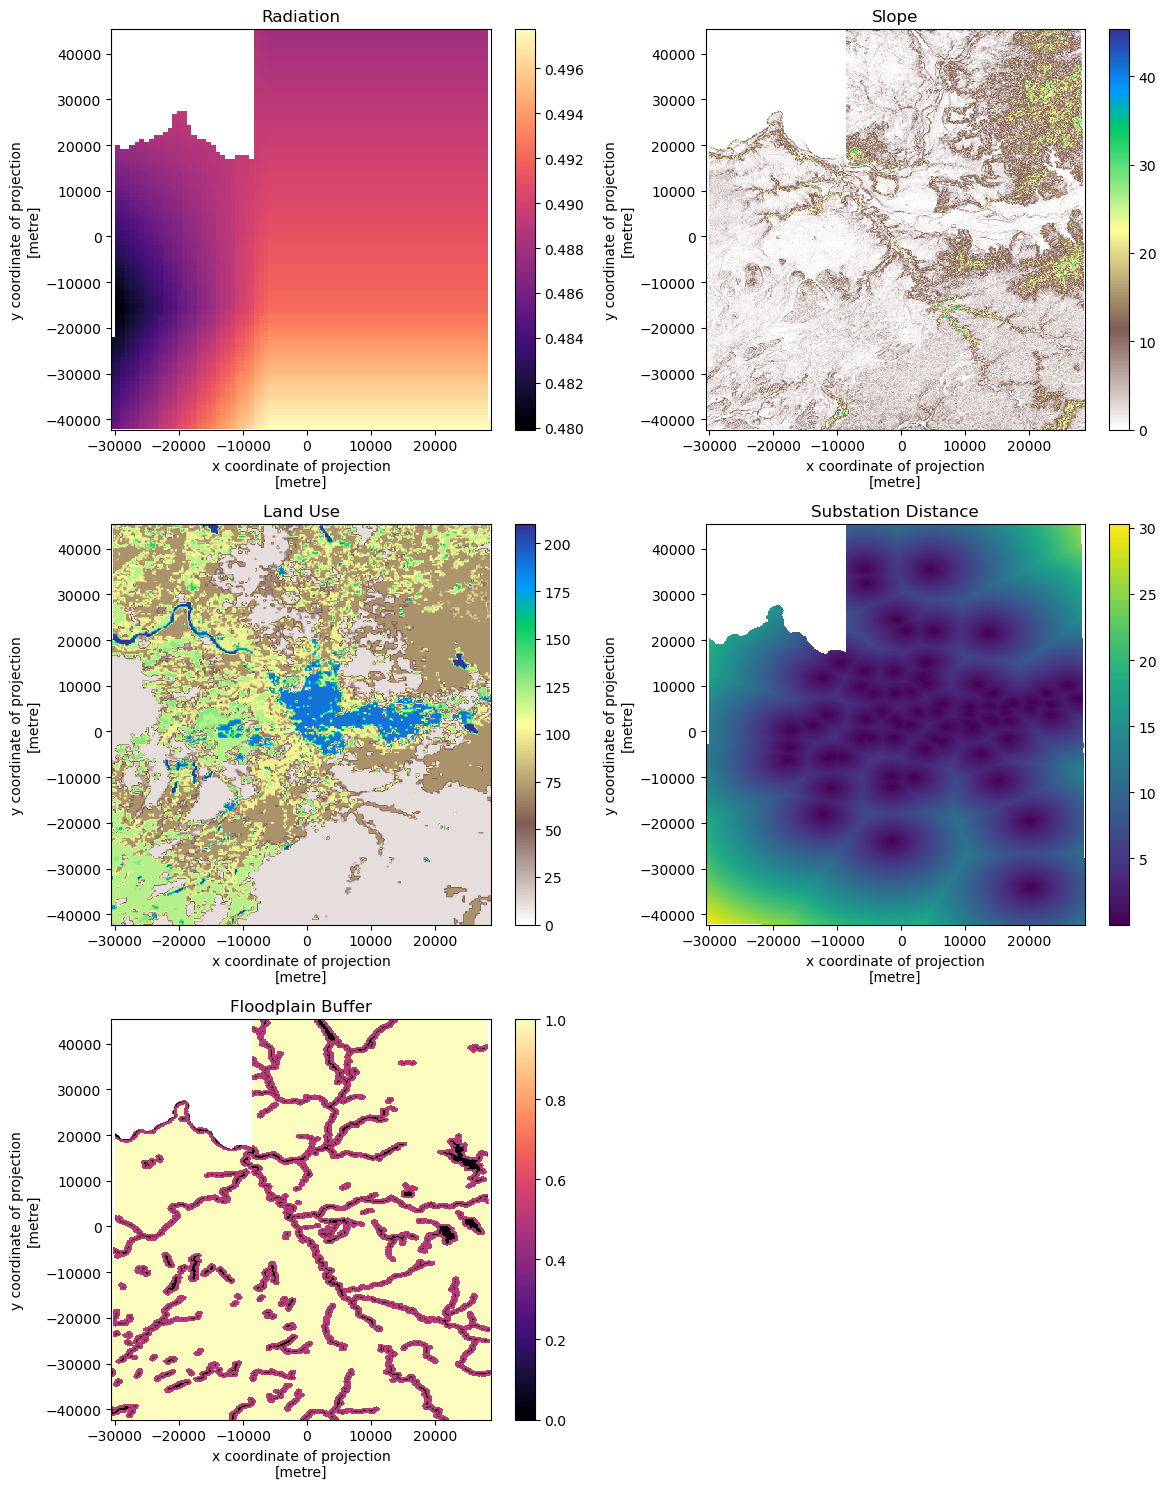

In [32]:
ds = [radiation, slope, land_use, substation_distance, floodplain_buffer]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['magma', 'terrain_r', 'terrain_r', 'viridis', 'magma']

n_rows = (len(ds) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

# Flatten axs in case there's only one row
axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

---
## Section 2B: Merging all data to XDarray Datafrane & Summary Table

In [33]:
floodplain_buffer.name = 'Flood_Zones'
substation_distance.name = 'Substation_Distance'
radiation.name = 'Radiation'
land_use.name = 'Land_Use'
slope.name = 'Slope'

In [144]:
merged_df = xr.merge([floodplain_buffer, 
                      slope, 
                      substation_distance, 
                      radiation, 
                      land_use])
merged_df

<xarray.Dataset> Size: 11MB
Dimensions:              (x: 593, y: 876)
Coordinates:
    band                 int64 8B 1
  * x                    (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.87e+04
  * y                    (y) float64 7kB 4.53e+04 4.52e+04 ... -4.22e+04
    spatial_ref          int64 8B 0
Data variables:
    Flood_Zones          (y, x) float32 2MB nan nan nan nan ... 1.0 1.0 1.0 1.0
    Slope                (y, x) float32 2MB nan nan nan nan ... 1.893 3.11 3.329
    Substation_Distance  (y, x) float32 2MB nan nan nan ... 11.57 11.64 11.71
    Radiation            (y, x) float64 4MB nan nan nan nan ... nan nan nan nan
    Land_Use             (y, x) uint8 519kB 0 0 0 113 69 58 ... 11 11 11 11 11
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Summary Table

In [145]:
st = merged_df.mean()
st = merged_df.to_dataframe().describe()
st

,band,spatial_ref,Flood_Zones,Slope,Substation_Distance,Radiation,Land_Use
count,519468.0,519468.0,461258.000000,460998.000000,461258.000000,458396.000000,519468.000000
mean,1.0,0.0,0.883075,4.543242,7.277742,0.490318,67.544268
std,0.0,0.0,0.242088,4.954040,5.613572,0.003321,48.313111
min,1.0,0.0,0.000000,0.000000,0.001652,0.479920,0.000000
25%,1.0,0.0,1.000000,1.227909,2.873534,0.488473,11.000000
50%,1.0,0.0,1.000000,2.754481,5.769769,0.490086,70.000000
75%,1.0,0.0,1.000000,5.875230,10.252606,0.492004,100.000000
max,1.0,0.0,1.000000,45.333660,30.263113,0.497737,210.000000


## Section 3: Classifying & Scaling DF 

In [154]:
scale = merged_df.copy()

In [164]:
original_values = merged_df["Land_Use"]

scale['Land_Use'] = xr.where((original_values >= 150) & (original_values <= 180) | (original_values >= 210), 0, scale['Land_Use'])  # Water/Snow
scale['Land_Use'] = xr.where((original_values == 190), 0, scale['Land_Use'])  # Urban Areas
scale['Land_Use'] = xr.where((original_values >= 10) & (original_values <= 20), 3, scale['Land_Use'])  # Farmland 
scale['Land_Use'] = xr.where((original_values >= 50) & (original_values <= 90) | (scale['Land_Use'] == 100), 0, scale['Land_Use'])  # Forests
scale['Land_Use'] = xr.where((original_values == 200), 6, scale['Land_Use'])  # Bare Areas
scale['Land_Use'] = xr.where((original_values == 30) | (original_values >= 110) & (scale['Land_Use'] <= 140), 5, scale['Land_Use']) # Grasslands

In [156]:
# Creates the scale for the substation distancce. Based on how far the substation is from each pixel
scale["Flood_Zones"] = merged_df.Flood_Zones * 6
# Always reference original values from merged_df, ensuring that things are not being overwritten in the original
original_values = merged_df["Substation_Distance"]

# Only update values in scale without overwriting previous changes
scale["Substation_Distance"] = xr.where(original_values <= 2.5, 6, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 2.5) & (original_values <= 5), 5, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 5) & (original_values <= 7.5), 4, scale["Substation_Distance"])

scale["Substation_Distance"] = xr.where((original_values >= 7.5) & (original_values < 10), 3, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 10) & (original_values <= 15), 2, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 15), 1, scale["Substation_Distance"])

In [157]:

original_values = merged_df["Slope"]

# Slope is ranked by the best, 6, being the lowest slopes, and the worst, one being the steepest
scale["Slope"] = xr.where(original_values <= 5, 6, scale["Slope"])
scale["Slope"] = xr.where((original_values > 5) & (original_values <= 10), 5, scale["Slope"])
scale["Slope"] = xr.where((original_values > 10) & (original_values <= 15), 4, scale["Slope"])

#Any slope above 15 too steep and gets a value of one
scale["Slope"] = xr.where(original_values >= 15, 1, scale["Slope"])


In [158]:
min_value = merged_df["Radiation"].min().item()
max_value = merged_df["Radiation"].max().item()
range_values = (max_value - min_value)/ 6

In [159]:
original_values = merged_df["Radiation"]

#Values seperated ransomly as the values are all within range for what is desired from a solar farm

scale["Radiation"] = xr.where((original_values > (max_value-range_values)) & (original_values <= max_value), 6, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value-range_values*2)) & (original_values <= (max_value - range_values)), 5, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value - range_values*3)) & (original_values <= (max_value - 2*range_values)), 4, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+ 2* range_values)) & (original_values <= (min_value + 3*range_values)), 3, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+range_values)) & (original_values <= (min_value + 2*range_values)), 2, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value)) & (original_values <= (min_value + range_values)), 1, scale["Radiation"])

In [165]:
## removes all the spots that are ether nan or 0 as those are the areas that are either outside the county border 
##    or have been marksed as flood plains. Removes these points from every raster.
scale = scale.where((scale.Flood_Zones.notnull()) & (scale.Flood_Zones != 0), drop=True)
scale = scale.where((scale.Land_Use.notnull()) & (scale.Land_Use != 0), drop=True)
#scale = scale.where(scale.Land_Use != 0, drop=True)

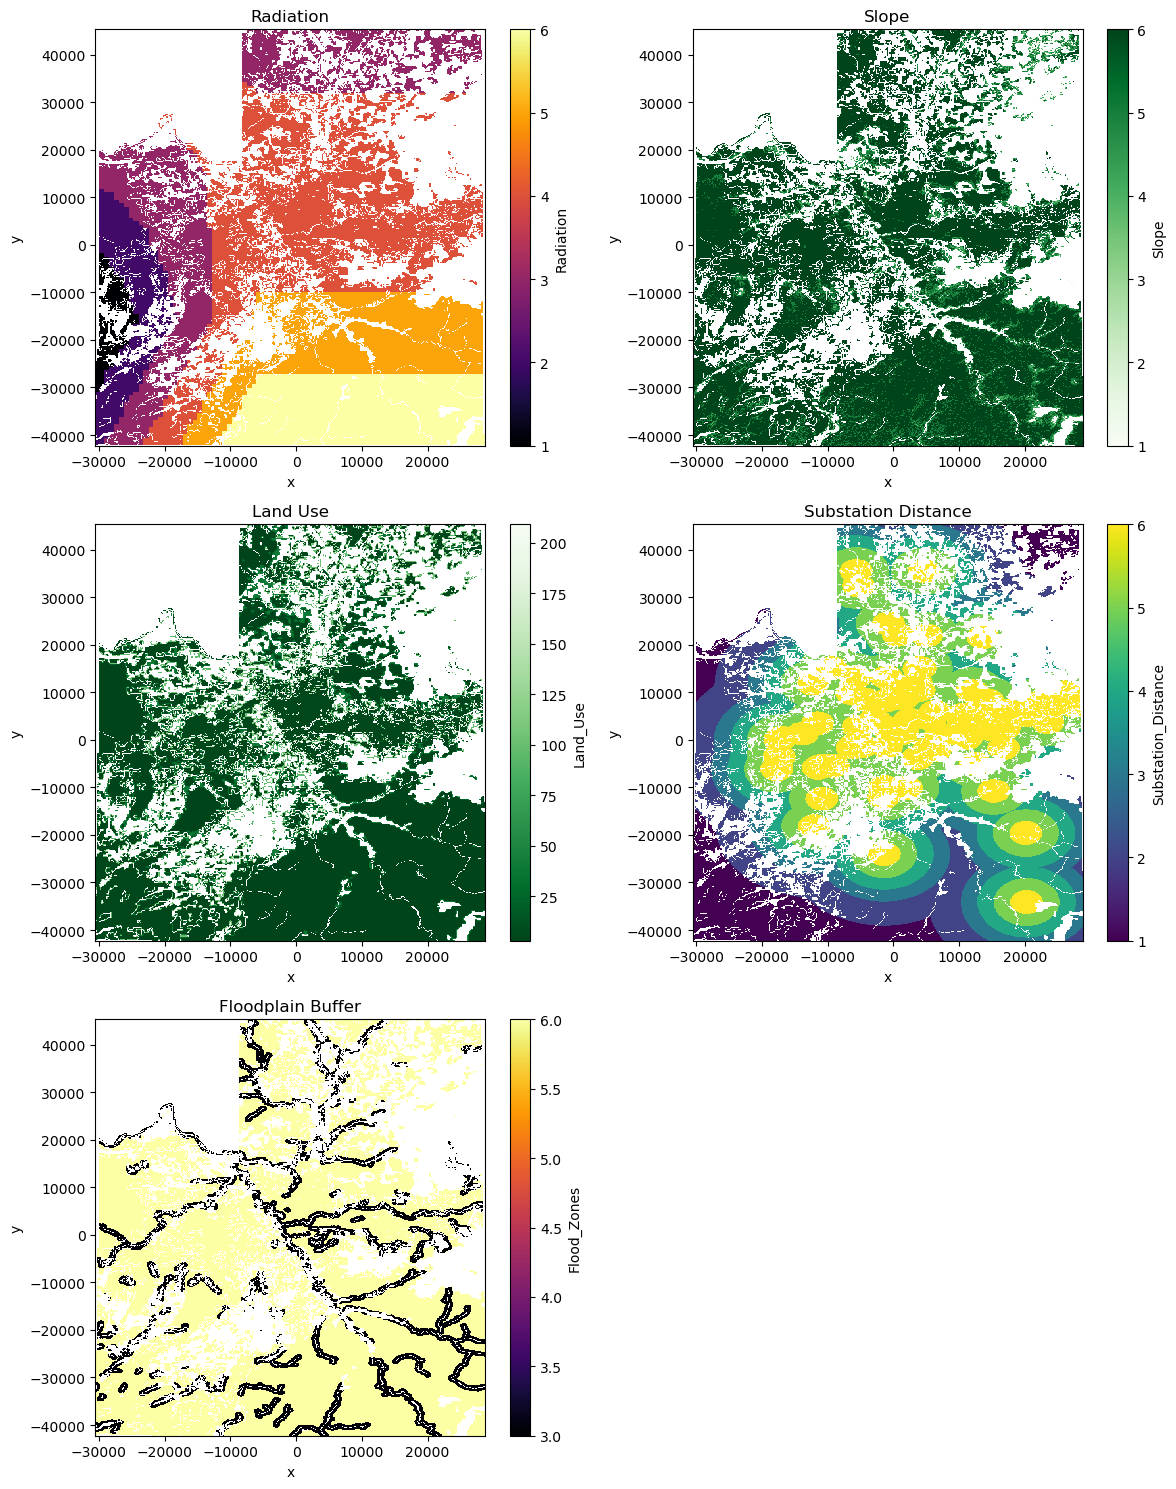

In [166]:
ds = [scale["Radiation"], scale["Slope"], scale["Land_Use"], scale["Substation_Distance"], scale["Flood_Zones"]]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['inferno', 'Greens', 'Greens_r', 'viridis', 'inferno']

n_rows = (len(ds) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

# Flatten axs in case there's only one row
axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Section 4: Score Weight Calculation

In [168]:
# It was determined that the score would be weighted based on the importance/influence of the variable
# The weight was based on what we thoguht was most important but was also somewhat arbitrary

# score = land use * 1 + substatin distacne * 1 + radiation * 0 .75 + slope * 1.25

net_score_unweighted = scale["Radiation"] + scale["Slope"] + scale["Substation_Distance"] + scale["Flood_Zones"]
net_score_weighted = scale["Radiation"] * 0.75 + scale["Slope"] * 1.25 + scale["Substation_Distance"] * 1 + scale["Flood_Zones"] * 0.25

scale["net_score_weighted"] = net_score_weighted
scale['net_score_unweighted']= net_score_unweighted


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

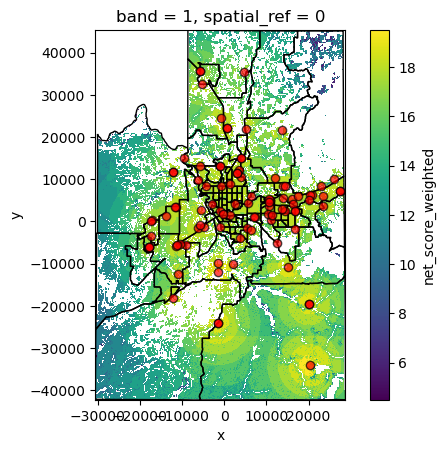

In [169]:
fig,ax = plt.subplots()
scale.net_score_weighted.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)


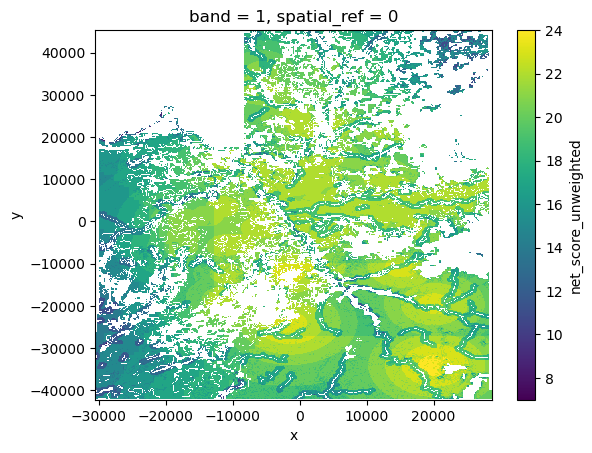

In [170]:
scale.net_score_unweighted.plot()

## Section 5: Finding 200 acre-ft areas

In [171]:
net_score_unweighted

<xarray.DataArray (y: 876, x: 593)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [15., 15., 15., ..., 20., 20., 20.],
       [15., 15., 15., ..., 20., 20., 20.],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.86e+04 2.87e+04
  * y            (y) float64 7kB 4.53e+04 4.52e+04 ... -4.21e+04 -4.22e+04
    spatial_ref  int64 8B 0

In [ ]:
scale_filtered = scale.where((scale.net_score_weighted > 22), drop=True)
scale_filtered.net_score_weighted.plot.imshow(vmin = 0, vmax= 22)

In [188]:
#Code Aquired from chatGBT

import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, Point
from affine import Affine


data = net_score_unweighted.values
pixel_size = 100  # meters

## Note: Cange the desired area size, in acres
area = 150


#Conversion of acres to m^2
acre_in_m2 = 4046.86


cell_area_m2 = area * acre_in_m2       
cell_side = np.sqrt(cell_area_m2)      # side length in meters (~636.37 m)

# Get the raster bounds based on the xarray coordinates.
x_coords = net_score_unweighted.coords['x'].values
y_coords = net_score_unweighted.coords['y'].values

# Assuming x and y are pixel center coordinates, compute the full extent:
x_min = x_coords[0] - pixel_size/2
x_max = x_coords[-1] + pixel_size/2
if y_coords[0] > y_coords[-1]:
    # y is descending (common in rasters)
    y_max = y_coords[0] + pixel_size/2
    y_min = y_coords[-1] - pixel_size/2
else:
    y_min = y_coords[0] - pixel_size/2
    y_max = y_coords[-1] + pixel_size/2

# Set up the affine transform for the raster.
# (This assumes the raster is north-up; adjust if your coordinate system is different.)
if y_coords[0] > y_coords[-1]:
    transform = Affine(pixel_size, 0, x_min,
                       0, -pixel_size, y_max)
else:
    transform = Affine(pixel_size, 0, x_min,
                       0, pixel_size, y_min)

# Build a grid covering the raster extent with cells of size "cell_side" x "cell_side".
grid_polygons = []
current_x = x_min
while current_x < x_max:
    current_y = y_min
    while current_y < y_max:
        # Create a polygon for this grid cell.
        cell_poly = box(current_x, current_y, current_x + cell_side, current_y + cell_side)
        grid_polygons.append(cell_poly)
        current_y += cell_side
    current_x += cell_side

# A helper function to compute pixel window indices for a given real-world bounding box.
def get_window_indices(xmin, xmax, ymin, ymax, transform, shape):
    inv_transform = ~transform
    # For a box, compute the indices for the top-left and bottom-right corners.
    col_min, row_min = map(int, inv_transform * (xmin, ymax))
    col_max, row_max = map(int, inv_transform * (xmax, ymin))
    # Clamp indices to the data array bounds.
    row_min = max(0, row_min)
    row_max = min(shape[0], row_max + 1)
    col_min = max(0, col_min)
    col_max = min(shape[1], col_max + 1)
    return row_min, row_max, col_min, col_max

# Loop over each grid cell. For each, we extract the subset of pixel values
# that lie within its bounding box and then verify (using the pixel center coordinates)
# that every pixel falling inside the cell is non-NaN.
cells = []
net_scores = []
for poly in grid_polygons:
    # Get the bounds of the polygon.
    xmin, ymin, xmax, ymax = poly.bounds
    # Get corresponding pixel indices.
    row_min, row_max, col_min, col_max = get_window_indices(xmin, xmax, ymin, ymax, transform, data.shape)
    if row_max <= row_min or col_max <= col_min:
        continue
    window_data = data[row_min:row_max, col_min:col_max]
    
    # Build a grid of pixel center coordinates for the window.
    rows, cols = np.indices(window_data.shape)
    # Compute real-world coordinates for each pixel center.
    xs, ys = transform * (cols + col_min + 0.5, rows + row_min + 0.5)
    
    # Create a mask: True for pixels whose center falls within the polygon.
    # (Note: This approach iterates over each pixel center.)
    inside = np.array([poly.contains(Point(x, y)) for x, y in zip(xs.ravel(), ys.ravel())])
    inside_mask = inside.reshape(window_data.shape)
    
    # If any pixel within the cell is NaN, skip this cell.
    if np.isnan(window_data[inside_mask]).any():
        continue
    
    # Sum the net score for pixels whose centers lie within the cell.
    cell_net_score = np.sum(window_data[inside_mask])
    cells.append(poly)
    net_scores.append(cell_net_score)

# Create a GeoDataFrame with the resulting grid cells and net score sums.

gdf = gpd.GeoDataFrame({'net_score': net_scores, 'geometry': cells}, crs=proj_str_aea)

print(gdf)


      net_score                                           geometry
0         959.0  POLYGON ((-29769.783 -39136.554, -29769.783 -3...
1         958.0  POLYGON ((-28990.662 -39136.554, -28990.662 -3...
2         960.0  POLYGON ((-28990.662 -36020.071, -28990.662 -3...
3         748.0  POLYGON ((-28990.662 -33682.709, -28990.662 -3...
4         958.0  POLYGON ((-28990.662 -32903.589, -28990.662 -3...
...         ...                                                ...
1978     1232.0  POLYGON ((27885.146 8389.806, 27885.146 9168.9...
1979     1280.0  POLYGON ((28664.266 -41473.916, 28664.266 -406...
1980     1132.0  POLYGON ((28664.266 -40694.795, 28664.266 -399...
1981      159.0  POLYGON ((29443.387 -41473.916, 29443.387 -406...
1982      140.0  POLYGON ((29443.387 -40694.795, 29443.387 -399...

[1983 rows x 2 columns]


Text(0.5, 1.0, 'Optimal Land Parcels')

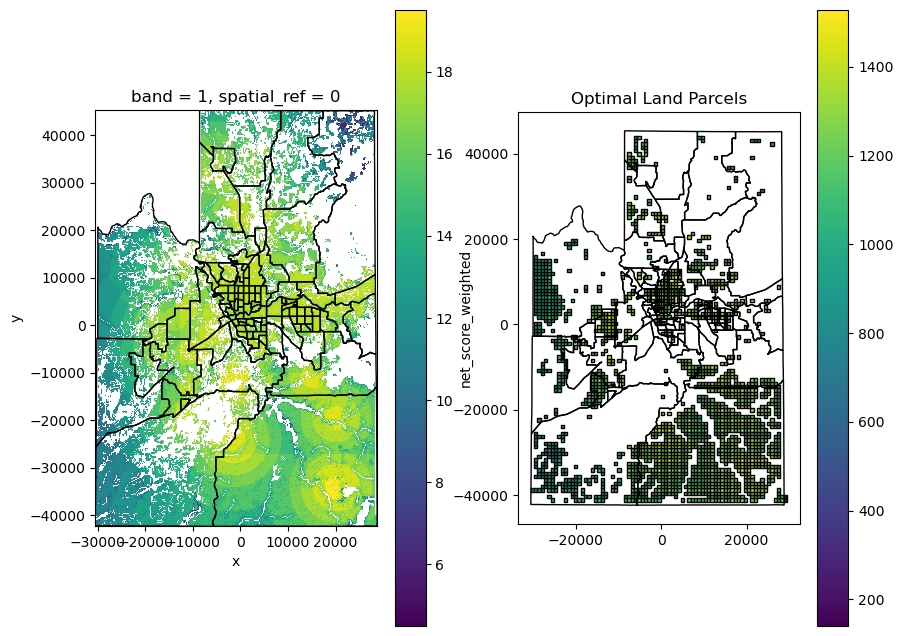

In [192]:
fig, ax = plt.subplots(1,2,figsize=(10, 8))

scale.net_score_weighted.plot(ax=ax[0])
tract_geom_gdf.plot(ax=ax[0], facecolor = 'none')

gdf.plot(column="net_score", cmap="viridis", edgecolor="black", legend=True, ax=ax[1])
#scale.net_score_weighted.plot(ax=ax[1])

tract_geom_gdf.plot(ax=ax[1], edgecolor="black", facecolor = 'none')
ax[1].set_title("Optimal Land Parcels")

# Random Plots

In [ ]:
# colors = {
#     1: 'lightblue',   # water/snow
#     2: 'sienna',      # urban
#     3: 'red', # farm
#     4: 'forestgreen', # forests
#     5: 'red',         # bare
#     6: 'red'          # grasslands
# }

# cmap = mcolors.ListedColormap([colors[i] for i in range(1, 7)])

# norm = mcolors.BoundaryNorm(np.arange(0.5, 7.5, 1), cmap.N)

# fig, ax = plt.subplots(figsize=(9, 6))
# im = land_classes.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# legend_patches = [
#     Patch(color=colors[1], label='Water & Snow'),
#     Patch(color=colors[2], label='Urban Areas'),
#     Patch(color=colors[3], label='Farm Land'),
#     Patch(color=colors[4], label='Forest Cover'),
#     Patch(color=colors[5], label='Bare Areas'),
#     Patch(color=colors[6], label='Grasslands')
# ]

# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# ax.legend(handles=legend_patches, bbox_to_anchor=(1, 1), loc='upper left', title='Land Use Classes')
# ax.set_title('Land Cover')

# plt.show()

In [ ]:
# fig,ax = plt.subplots()

# radiation.plot.imshow(ax=ax)
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

# plt.title("Spokane UV Map")
# plt.show()

In [ ]:
# fig,ax = plt.subplots(figsize=(9,7))

# substation_distance_raster_data.plot(ax=ax)
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

# substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)

# plt.suptitle('Substation distance')

In [ ]:
# fig,ax = plt.subplots()
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# census_Spokane_gdf.plot(ax=ax, column="TotalPopulation")
# plt.title("Population Density")
# plt.show()

In [ ]:
# fig,ax = plt.subplots()

# slope_Spokane.plot.imshow(ax=ax, alpha=0.75, vmin=0, vmax = 40,cmap="magma_r")
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# plt.title("Spokane County Slope Map")
# plt.show()

In [ ]:
# f,ax=plt.subplots()
# floodplains_gdf.plot(ax=ax)
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

In [ ]:
# fig,ax = plt.subplots()

# #floodplains_gdf.plot(ax=ax)
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# slope_Spokane.plot.imshow(ax=ax, alpha=0.5, vmin=0, vmax = 40,cmap="magma_r")

# plt.title("Spokane County: Flood Plain Overlapped with Flood Plains")
# plt.show()

In [ ]:
# fig,ax = plt.subplots()

# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# substation_gdf.plot(ax=ax, color='blue', edgecolor='black')

# plt.title('Substations in Washington (WA)')

In [ ]:
# fig,ax = plt.subplots()

# substation_gdf.plot(ax=ax, color='blue', edgecolor='black')
# radiation.plot.imshow(ax = ax, alpha=0.75)
# floodplains_gdf.plot(ax=ax)
# tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
# slope_Spokane.plot.imshow(ax=ax, alpha=0.5, vmin=0, vmax = 40,cmap="magma_r")

In [ ]:
# fig,ax = plt.subplots()

# floodplain_binary_data.plot(ax = ax)
# tract_geom_gdf.plot(ax = ax, edgecolor="black", facecolor = 'none')